# Simple Video Pipeline Reading From Multiple Files

### Goal
In this example, we will show how to read video files using the [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) operator.
The reader returns batches of frame sequences. These sequences are an arbitrary number of frames (images). The difference being that images are of dimension `HWC` whereas sequences are of dimension `FHWC`.

For more information on the [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) parameters, please look at the documentation.

## Setting Up

First let's start with the imports:

In [1]:
import os
from itertools import islice
from pathlib import Path

import nvidia.dali.experimental.dynamic as ndd

We need some video containers to process. We can use [Sintel](https://en.wikipedia.org/wiki/Sintel) trailer, which is an mp4 container containing an h264 video and distributed under the Creative Commons license. Let's split it into 10s clips in order to check how `readers.Video` handles multiple video files. This can be done easily with the `ffmpeg` standalone tool. 

Then we can set the parameters that will be used by the reader. The `sequence_length` parameter defines how many frames we want in each sequence sample.

We can replace `video_directory` with any other directory containing video container files recognized by **FFmpeg**.

In [2]:
batch_size = 2
sequence_length = 8
initial_prefetch_size = 16
dali_extra_dir = Path(os.environ["DALI_EXTRA_PATH"])
video_directory = dali_extra_dir / "db" / "video" / "sintel" / "video_files"
video_files = [str(video_directory / f) for f in os.listdir(video_directory)]
n_iter = 6

<div class="alert alert-info">

   Note<br>

   `DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.
</div>

## Reading Video Files

We create a [readers.Video](../../../../dali_dynamic/operations/nvidia.dali.experimental.dynamic.readers.Video.html) instance with the video files and parameters:

In [3]:
reader = ndd.readers.Video(
    device="gpu",
    filenames=video_files,
    sequence_length=sequence_length,
    shard_id=0,
    num_shards=1,
    random_shuffle=True,
    initial_fill=initial_prefetch_size,
    file_list_include_preceding_frame=True,
    seed=123456,
)

<div class="alert alert-warning">

   Caution<br>

   One important thing here is tuning `initial_fill`, which corresponds to the reader prefetch buffer initial size. Since this buffer will be filled with `initial_fill` sequences, the total number of frames can be really huge! So set it accordingly to avoid running out of memory during training.
</div>

We can now iterate over batches of video sequences. Each batch contains `batch_size` sequences, and each sequence contains `sequence_length` frames.

In [4]:
for (videos,) in islice(reader.next_epoch(batch_size=batch_size), n_iter):
    print(ndd.as_tensor(videos).shape)

(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)


(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)
(2, 8, 720, 1280, 3)


(2, 8, 720, 1280, 3)


### Visualizing the Results

The previous iterations seem to have yielded batches of the expected shape. We will use matplotlib to display the frames we obtained in the last batch.

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [6]:
def show_sequence(sequence: ndd.Tensor):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

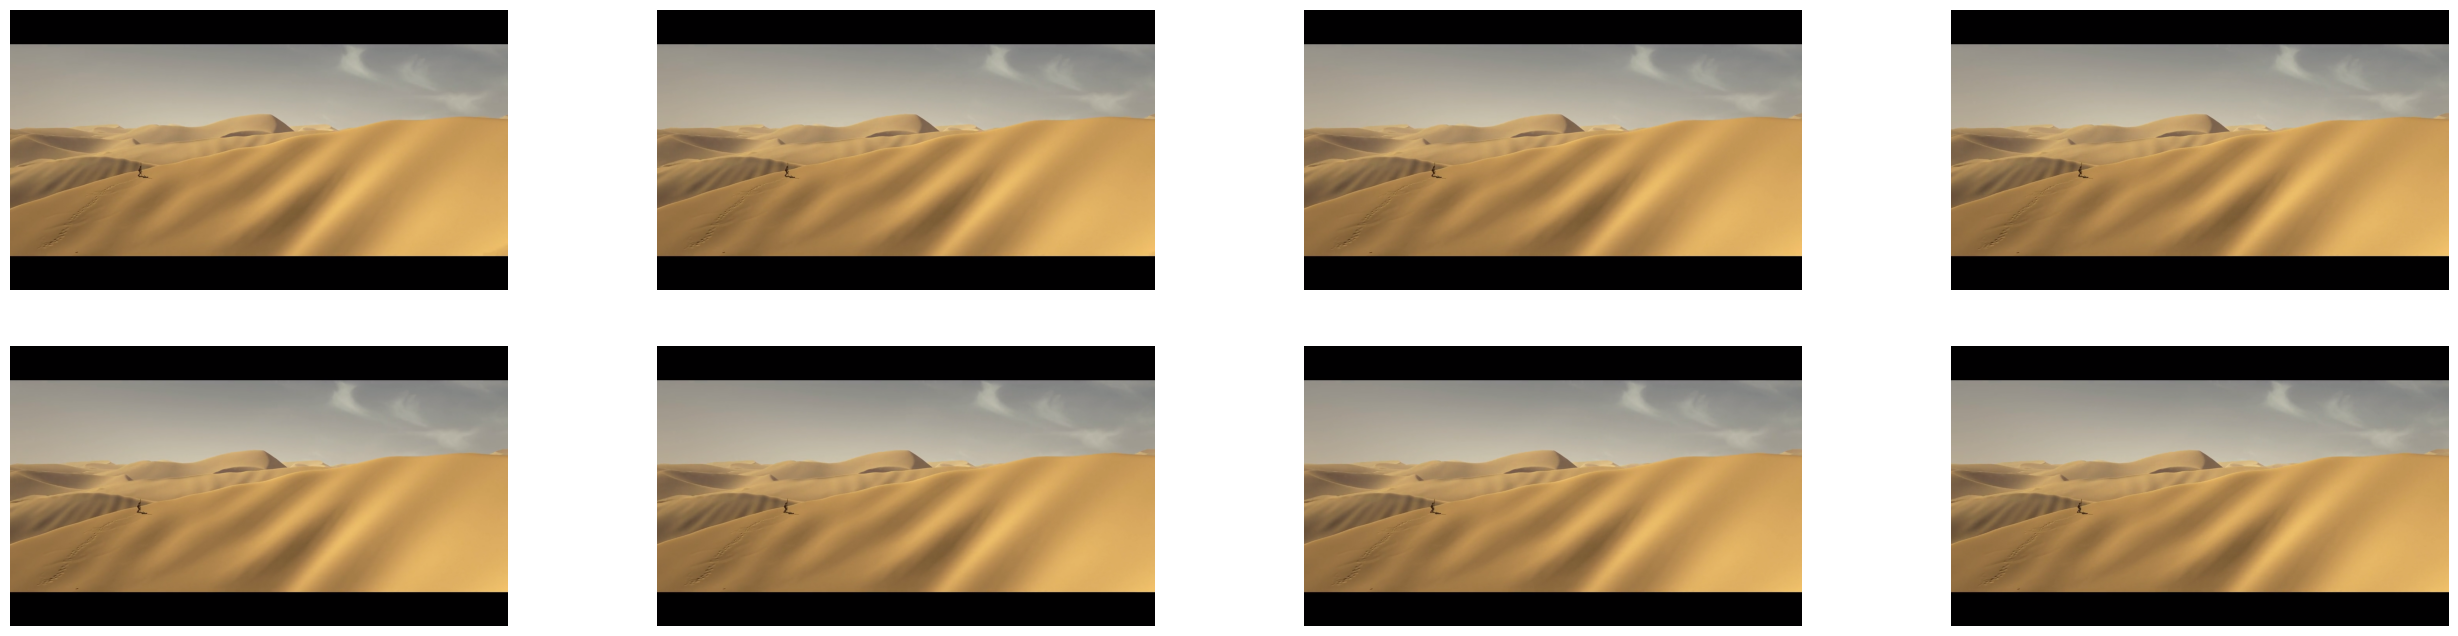

In [7]:
# Use the last batch from above
show_sequence(videos.select(0).cpu())